In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [3]:
#On modifie les options pour rendre l'affichage des float plus lisible
pd.set_option('float_format', '{:f}'.format)

In [4]:
#On définit les colonnes du dataset qui nous serons utiles 
fields = ['code', 'product_name','generic_name','brands','categories','origins','labels','cities','purchase_places','stores','countries','ingredients_text','allergens','additives_n','nutriscore_score','nutriscore_grade','nova_group','pnns_groups_1','pnns_groups_2','ecoscore_score_fr','ecoscore_grade_fr','main_category','image_url','energy-kj_100g',
'energy-kcal_100g','salt_100g','sodium_100g','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','carbohydrates_100g','alcohol_100g','fruits-vegetables-nuts_100g']

df = pd.read_csv("en.openfoodfacts.org.products.csv", sep='\t', usecols=fields)

Les colonnes ont été choisies en fonction de nos besoins pour l'application et suite à diverses recherches et tests statistiques sur le dataset

Dans un premier temps nous allons jeter un oeil à la qualité de la donnée en visualisant le nombre de valeurs nulles grâce à la librairie MissingNo

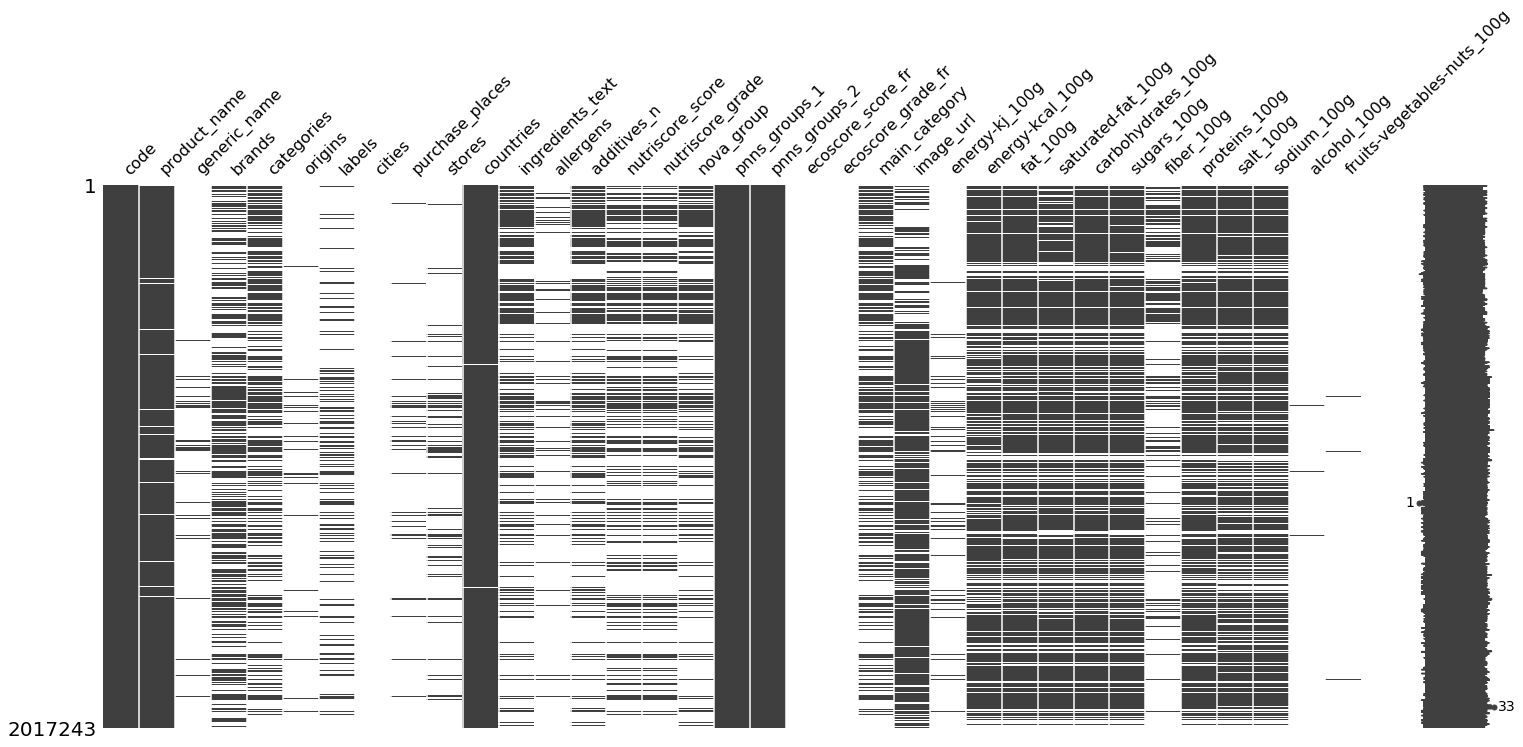

In [5]:
msno.matrix(df)

Ensuite nous allons vérifier le nombre de produits dans le dataset puis commencer à éliminer toutes les entrées ne correspondant pas à nos besoins pour l'application. Ici nous retirerons alors les données dont le nom est absent ainsi que les données de produits non français par soucis de lisibilité et de disponibilité en magasin.

In [6]:
print("Données de base : ")
print(df['code'].describe())

Données de base : 
count         2017243
unique        2016995
top       84909900098
freq                3
Name: code, dtype: int64


In [7]:
df = df[df['product_name'].str.strip().astype(bool)]
print("Après filtre non vide : ")
print(df['code'].describe())

Après filtre non vide : 
count         2017242
unique        2016994
top       84909900098
freq                3
Name: code, dtype: int64


In [8]:
df = df[df['countries'] == 'France']
print("Après filtre France : ")
print(df['code'].describe())

Après filtre France : 
count             435377
unique            435369
top       30383354190402
freq                   2
Name: code, dtype: object


In [9]:
df['categories'].replace('', np.nan, inplace=True)
df.dropna(subset=['categories'], inplace=True)
print(df['code'].describe())

count             263290
unique            263285
top       31843340000818
freq                   2
Name: code, dtype: int64


Nous supprimons toutes les catégories vides car il nous est impossible de proposer un produit similaire au produit entré sans connaitre sa catégorie

Nous allons maintenant utiliser la librairie Missingno afin de voir la quantité de données vides dans notre jeu de données

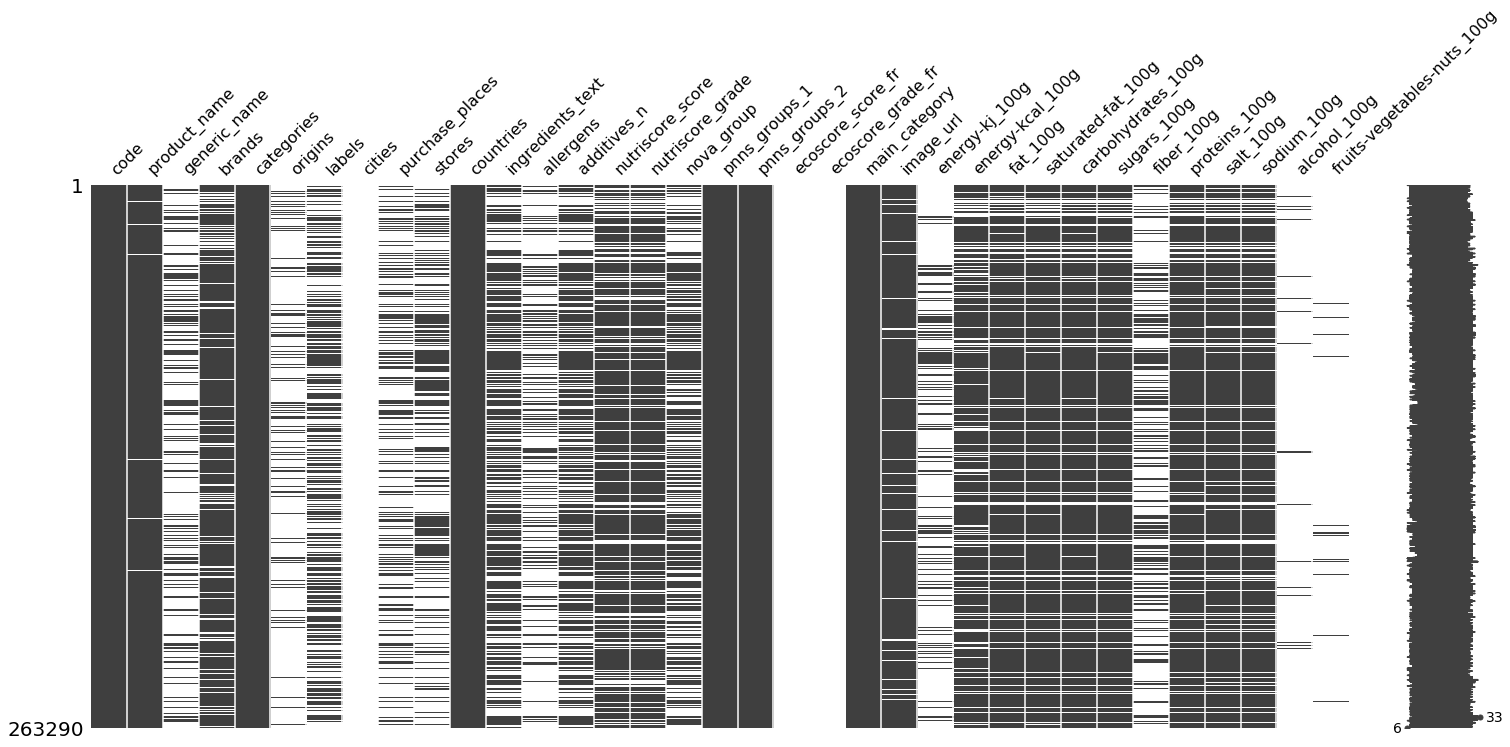

In [10]:
msno.matrix(df)

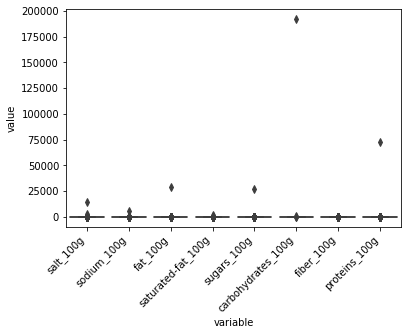

In [11]:
boxplots = pd.DataFrame(data=df, columns=["salt_100g","sodium_100g","fat_100g","saturated-fat_100g","sugars_100g","carbohydrates_100g","fiber_100g","proteins_100g"])
sns.boxplot(x="variable", y="value", data=pd.melt(boxplots))
plt.xticks(rotation=45, ha='right')
plt.show()

On remarque assez vite ici qu'il y a des valeurs dépassant le seuil de 100grammes. Il s'agit probablement de valeurs entrées en miligrammes au lieu de grammes mais nous allons les supprimer car cela demanderait une vérification manuelle pour chaque produit.

Nous allons donc procéder à un nettoyage de toutes les valeurs en dehors des bornes 0 à 100, sauf pour le sodium qui sera entre les bornes 0 à 40 car il ne peut pas excéder cette valeur, nous verrons pourquoi par la suite.

In [12]:
df = df[df['salt_100g']>=0]
df = df[df['salt_100g']<=100.0]

df = df[df['sodium_100g']>=0]
df = df[df['sodium_100g']<=40]

df = df[df['fat_100g']>=0]
df = df[df['fat_100g']<=100.0]

df = df[df['saturated-fat_100g']>=0]
df = df[df['saturated-fat_100g']<=100.0]

df = df[df['sugars_100g']>=0]
df = df[df['sugars_100g']<=100.0]

df = df[df['fiber_100g']>=0]
df = df[df['fiber_100g']<=100.0]

df = df[df['carbohydrates_100g']>=0]
df = df[df['carbohydrates_100g']<=100.0]

df = df[df['proteins_100g']>=0]
df = df[df['proteins_100g']<=100.0]

Nous estimerons également que toutes les valeurs nulles pour la colonne alcohol_100g sont des produits ne contenant pas d'alcool, nous les mettrons alors d'office à 0 grammes pour la suite de nos calculs

In [13]:
df['alcohol_100g'] = df['alcohol_100g'].fillna(0)

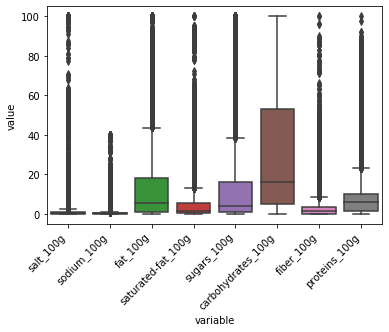

In [14]:
boxplots = pd.DataFrame(data=df, columns=["salt_100g","sodium_100g","fat_100g","saturated-fat_100g","sugars_100g","carbohydrates_100g","fiber_100g","proteins_100g"])
sns.boxplot(x="variable", y="value", data=pd.melt(boxplots))
plt.xticks(rotation=45, ha='right')
plt.show()

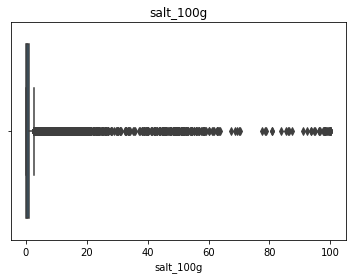

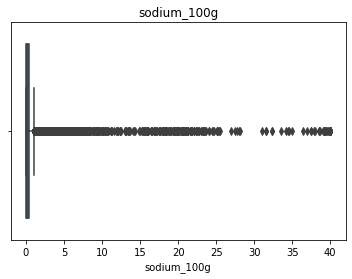

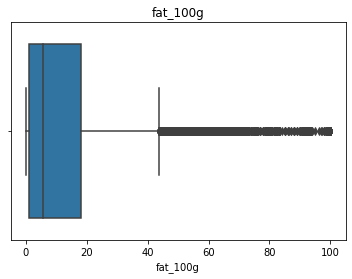

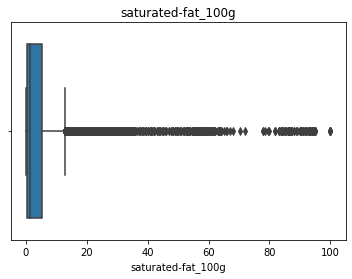

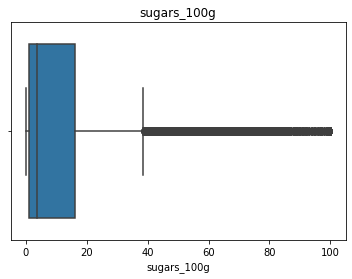

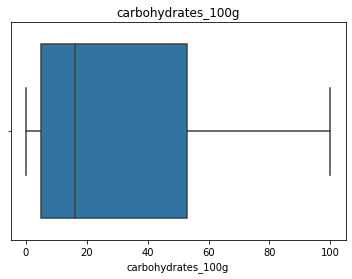

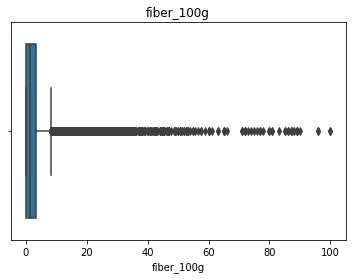

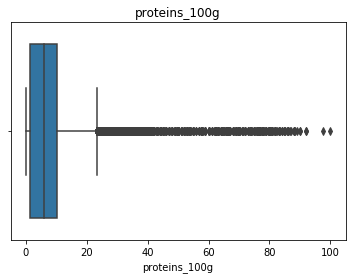

In [15]:
for var in ["salt_100g","sodium_100g","fat_100g","saturated-fat_100g","sugars_100g","carbohydrates_100g","fiber_100g","proteins_100g"]:
    sns.boxplot(x=var, data=df)
    plt.title(var)
    plt.show()

In [16]:
print(df['code'].describe())

count              86429
unique             86428
top       30383354190402
freq                   2
Name: code, dtype: object


Nous avons maintenant des boxplot correspondant bien mieux à ce que l'on pouvait s'attendre. On remarque également que le boxplot de sel et celui de sodium ont l'air similaires à leur échelle. Il est donc intéressant de voir s'il y a des corrélations entre les différentes variables que nous avons.

Pour cela nous allons réaliser une heatmap relevant les corrélations entre chacune de ces variables sur une échelle de 1 à 10:

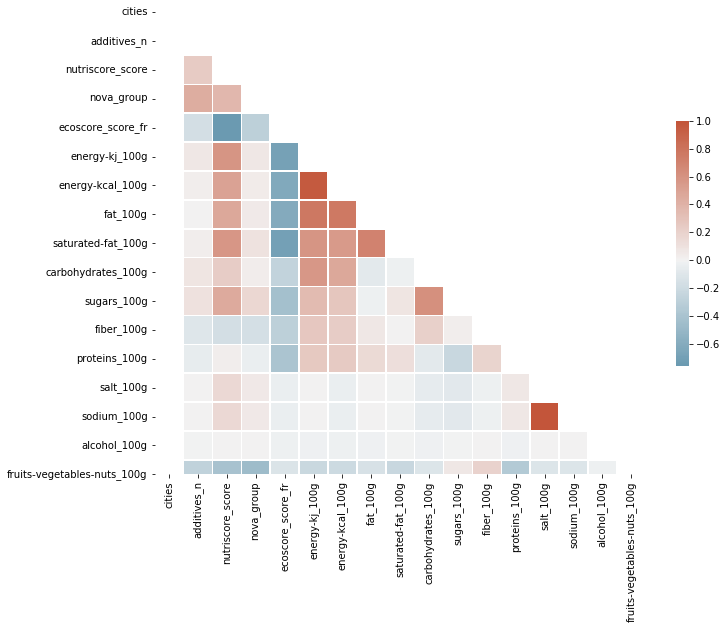

In [17]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nous pouvons distinguer que le sel et le sodium sont très corrélés ainsi que la graisse et la graisse saturée, nous allons donc tester ces valeurs avec un scatterplot pour déterminer s'il y a une relation entre ces deux variables

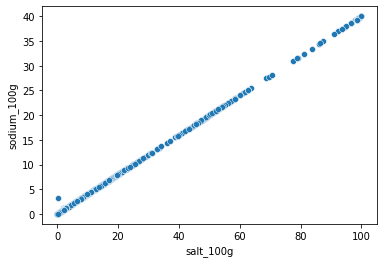

In [18]:
dfSample = df.sample(50000) # Nous prenons un échantillon de 50 000 entités pour accélérer le processus
xdataSample, ydataSample = dfSample["salt_100g"], dfSample["sodium_100g"]

sns.scatterplot(data=dfSample, x="salt_100g", y="sodium_100g") 
plt.show()

Nous pouvons effectivement voir une belle relation entre ces deux variables grâce à cette diagonale sur le graphique.

Après quelques recherches nous trouvons rapidement qu'il existe bel et bien une relation d'un coefficient de 2,54 entre ces deux variables (1gramme de sodium équivaut à 2,54 grammes de sel), ce qui nous permet de savoir qu'il n'y aura jamais plus de 40grammes de sodium dans une portion de 100grammes d'aliment

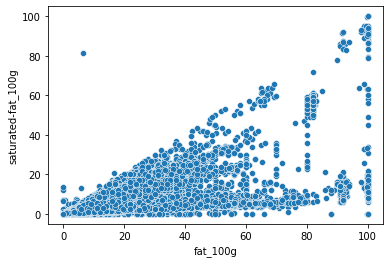

In [19]:
dfSample = df.sample(50000) # Nous prenons un échantillon de 50 000 entités pour accélérer le processus
xdataSample, ydataSample = dfSample["fat_100g"], dfSample["saturated-fat_100g"]

sns.scatterplot(data=dfSample, x="fat_100g", y="saturated-fat_100g") 
plt.show()

Pour les graisses et les graisses saturées nous pouvons également relever une corrélation mais il n'y a pas de coefficient visible entre ces deux variables. On peut néamoins remarquer qu'il parait impossible que les graisses saturées dépasse le taux de graisses, mis à part quelques cas qui sont potentiellement des erreurs.

Maintenant que nous connaissons la relation entre le sel et le sodium nous allons pouvoir procéder à une vérification pour chaque produit afin d'être sur que les données soient qualitatives

In [20]:
print("Avant vérification :",df["code"].count())
df = df.loc[abs(df['salt_100g']-df['sodium_100g']*2.54) < df['salt_100g']*0.05]
print("Après vérification :",df["code"].count())



Avant vérification : 86429
Après vérification : 74552


En ayant mis une tolérance de 5% de différence entre les valeurs données et les valeurs calculées nous avons quand même exclus une bonne partie des données qui sont potentiellement erronées

En faisant nos recherches sur la relation entre le sel et le sodium nous avons découvert que la graisse comprends les graisses saturées et que les glucides comprennent le sucre et les fibres.
Nous pouvons donc vérifier que ces valeurs ne dépassent pas le taux de graisse et le taux de glucides liés.

In [21]:
print("Avant vérification :",df["code"].count())
df = df.loc[df['fat_100g'] >= df['saturated-fat_100g']]
print("Après vérification :",df["code"].count())


Avant vérification : 74552
Après vérification : 74486


In [22]:
print("Avant vérification :",df["code"].count())
df = df.loc[df['carbohydrates_100g'] >= df['sugars_100g']+df["fiber_100g"]]
print("Après vérification :",df["code"].count())

Avant vérification : 74486
Après vérification : 59266


Nous pouvons donc déduire avec ces dernières informations que toutes nos variables sont regroupées dans les 4 plus importantes, à savoir : graisses, glucides, protéines, sel.
Il est donc important de vérifier que la somme de ces 4 variables ne dépasse pas 100grammes.

In [23]:
print("Avant vérification :",df["code"].count())
df = df.loc[df['fat_100g'] + df['carbohydrates_100g']+df["salt_100g"]+df["proteins_100g"]<=100]
print("Après vérification :",df["code"].count())

Avant vérification : 59266
Après vérification : 59088


Nous allons maintenant réutiliser Missingno afin de voir si nos données sont toutes remplies ou non

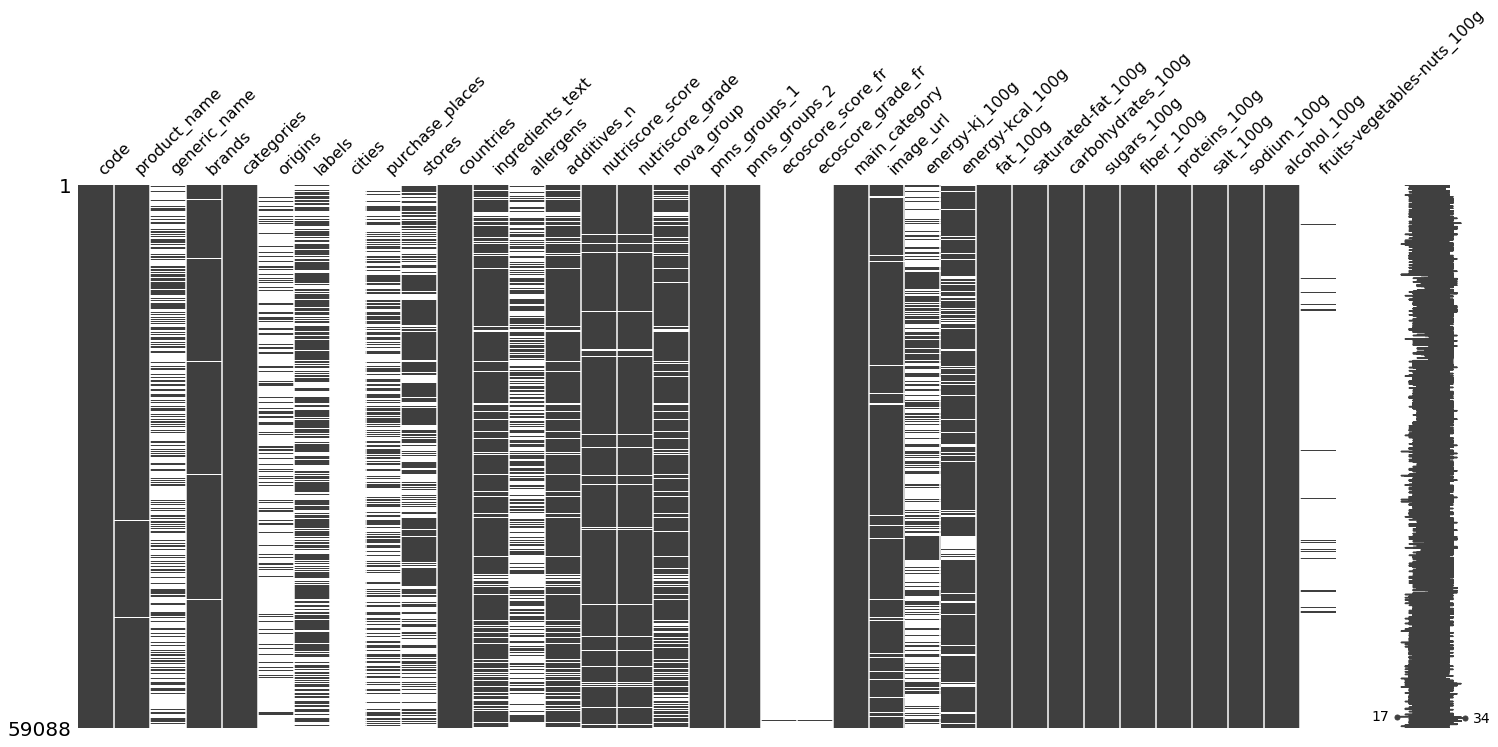

In [24]:
msno.matrix(df)

On peut remarquer ici que les colonnes comprenant les valeurs nutritives de l'aliment sont complètement remplies, ce qui va nous permettre de recalculer les valeurs manquantes de la valeur énérgétique en kcal et kj ainsi que le nutriscore.

En effet, la valeur énergétique en kcal d'un produit est égale à : glucides(gr) \* 4 + protéines(gr) \* 4 + graisses(gr) \* 9 + Alcool(gr) \* 7

On sait également que la valeur en kj d'un produit est égale à : kcal * 4.184
Maintenant que l'on sait que notre valeur en kcal est correcte, on peut remplacer toutes les valeurs en kj sans distinction

In [25]:
df['energy-kcal_100g']=df['fat_100g']*9+df['carbohydrates_100g']*4+df['proteins_100g']*4+df['alcohol_100g']*7
df['energy-kj_100g']=df['energy-kcal_100g']*4.184

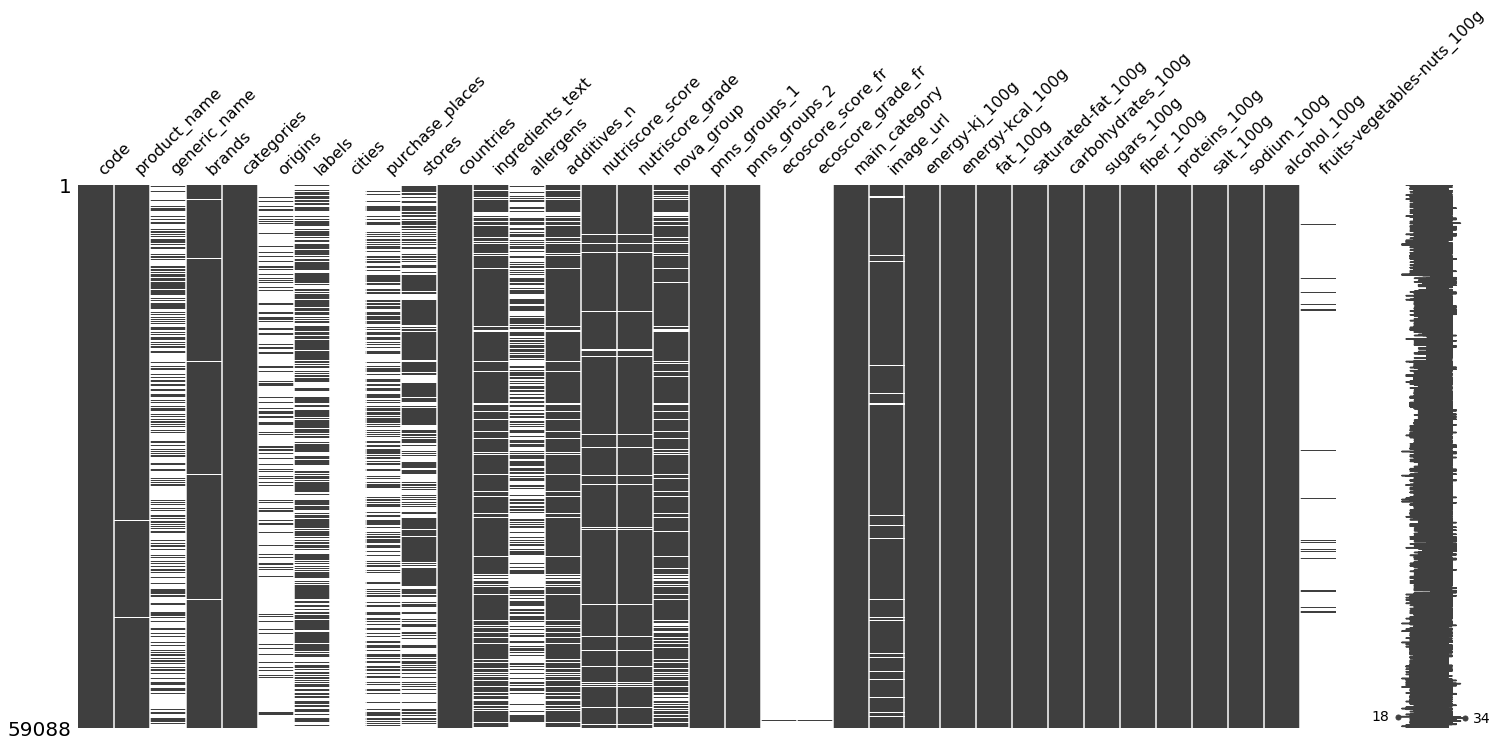

In [26]:
msno.matrix(df)

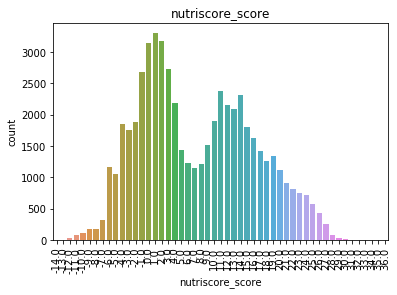

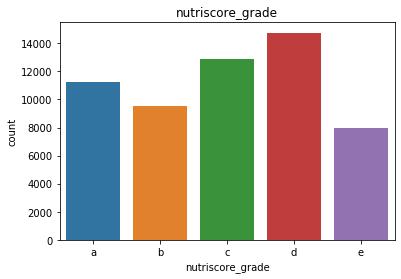

In [27]:
sns.countplot(x="nutriscore_score", data=df)
plt.title("nutriscore_score")
plt.xticks(rotation=90)
plt.show()


sns.countplot(x="nutriscore_grade", data=df, order =["a","b","c","d","e"])
plt.title("nutriscore_grade")
plt.show()

In [28]:
#Calcul du nutriscore

for index, row in df.iterrows():
    point_n = 0
    sugar = row["sugars_100g"]
    energy = row["energy-kj_100g"]
    if("Boissons" in row["categories"]):
        point_n += 10 if sugar > 45 else (9 if sugar > 40 else (8 if sugar > 36 else(7 if sugar > 31 else(6 if sugar > 27 else(5 if sugar > 22.5 else(4 if sugar > 18 else(3 if sugar > 13.5 else(2 if sugar > 9 else(1 if sugar > 4.5 else 0)))))))))
        point_n += 10 if energy > 270 else (9 if energy > 240 else (8 if energy > 210 else(7 if energy > 180 else(6 if energy > 150 else(5 if energy > 120 else(4 if energy > 90 else(3 if energy > 60 else(2 if energy > 30 else(1 if energy > 0 else 0)))))))))
    else:
        point_n += 10 if sugar > 13.5 else (9 if sugar > 12 else (8 if sugar > 10.5 else(7 if sugar > 9 else(6 if sugar > 7.5 else(5 if sugar > 6 else(4 if sugar > 4.5 else(3 if sugar > 3 else(2 if sugar > 1.5 else(1 if sugar > 0 else 0)))))))))
        point_n += 10 if energy > 3350 else (9 if energy > 3015 else (8 if energy > 2680 else(7 if energy > 2345 else(6 if energy > 2010 else(5 if energy > 1675 else(4 if energy > 1340 else(3 if energy > 1005 else(2 if energy > 670 else(1 if energy > 335 else 0)))))))))
    saturated_fat = row["saturated-fat_100g"]
    if("Matières grasses" in row["categories"]):
        point_n += 10 if saturated_fat >= 64 else (9 if saturated_fat >= 58 else (8 if saturated_fat >= 52 else(7 if saturated_fat >= 46 else(6 if saturated_fat >= 40 else(5 if saturated_fat >= 34 else(4 if saturated_fat >= 28 else(3 if saturated_fat >= 22 else(2 if saturated_fat >= 16 else(1 if saturated_fat >= 10 else 0)))))))))
    else:
        point_n += 10 if saturated_fat > 10 else (9 if saturated_fat > 9 else (8 if saturated_fat > 8 else(7 if saturated_fat > 7 else(6 if saturated_fat > 6 else(5 if saturated_fat > 5 else(4 if saturated_fat > 4 else(3 if saturated_fat > 3 else(2 if saturated_fat > 2 else(1 if saturated_fat > 1 else 0)))))))))
    sodium = row["sodium_100g"]
    point_n += 10 if sodium > 900 else (9 if sodium > 810 else (8 if sodium > 720 else(7 if sodium > 630 else(6 if sodium > 540 else(5 if sodium > 450 else(4 if sodium > 360 else(3 if sodium > 270 else(2 if sodium > 180 else(1 if sodium > 90 else 0)))))))))
    
    point_p = 0
    point_fruits = 0
    point_fibers = 0
    point_proteins = 0
    fruits = row["fruits-vegetables-nuts_100g"]    
    fibers = row["fiber_100g"]
    proteins = row["proteins_100g"]
    if("Boissons" in row["categories"]):
        point_fruits += 10 if fruits >80 else (4 if fruits >60 else (2 if fruits >40 else 0))
    else:
        point_fruits += 5 if fruits > 80 else (2 if fruits > 60 else (1 if fruits > 40 else 0))
    point_fibers += 5 if fibers > 3.5 else (4 if fibers > 2.8 else (3 if fibers > 2.1 else (2 if fibers > 1.4 else (1 if fibers > 0.7 else 0))))
    point_proteins += 5 if proteins > 8 else (4 if proteins > 6.4 else (3 if proteins > 4.8 else (2 if proteins > 3.2 else (1 if proteins > 1.6 else 0))))
    
    point_p = point_fruits + point_fibers + point_proteins
    
    #Choix de la méthode de calcul du nutriscore:
    if("Matières grasses" in row["categories"] or point_n < 11):
        score = point_n - point_p
    elif(point_fruits <5):
        score = point_n - (point_fibers + point_fruits)
    else :
        score = point_n - point_p
    
    #Réattribution du score 
    df.loc[index, 'nutriscore_score'] = score

    #Réattribution du rang
    if(score <0 and "Boissons" not in ["categories"]):
        df.loc[index, 'nutriscore_grade'] = "a"
    elif(0 <= score <= 2 and "Boissons" not in ["categories"]):
        df.loc[index, 'nutriscore_grade'] = "b"
    elif(3 <= score <= 10 and "Boissons" not in ["categories"] or (2 <= score <= 5 and "Boissons" in ["categories"])):
        df.loc[index, 'nutriscore_grade'] = "c"
    elif(11 <= score <= 18 and "Boissons" not in ["categories"] or (6 <= score <= 9 and "Boissons" in ["categories"])):
        df.loc[index, 'nutriscore_grade'] = "d"
    elif(19 <= score and "Boissons" not in ["categories"] or (10 <= score and "Boissons" in ["categories"])):
        df.loc[index, 'nutriscore_grade'] = "e"

Le nutriscore est recalculé entièrement pour tous les produits afin de vérifier avec nos données nettoyées si les scores correspondent toujours. Ensuite on attribue le rang de nutriscore en fonction du score obtenu avec nos variables.

On a choisi de ne pas modifier le rang pour les boissons en dessous du score de 2 car il nous était impossible de déterminer si la boisson était de l'eau ou non, le rang reste donc le même qu'avant le calcul.

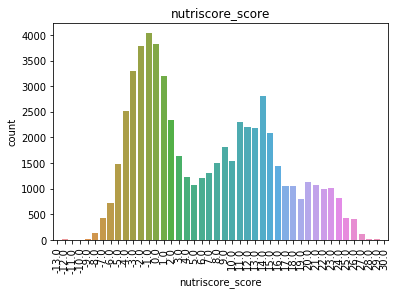

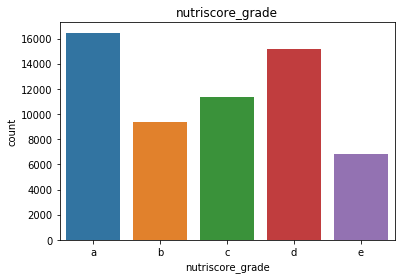

In [29]:
sns.countplot(x="nutriscore_score", data=df)
plt.title("nutriscore_score")
plt.xticks(rotation=90)
plt.show()


sns.countplot(x="nutriscore_grade", data=df, order =["a","b","c","d","e"])
plt.title("nutriscore_grade")
plt.show()

On peut voir ici que les deux graphiques correspondent complètement aux deux autres graphiques réalisés avec les données avant calcul. On peut donc déduire que notre formule est correcte.

In [30]:
df["image_url"] = df["image_url"].fillna('no_image.jpg')

On remplit les champs vides des images par un lien vers une image donnée pour afficher le fait que l'image est manquante sur notre application

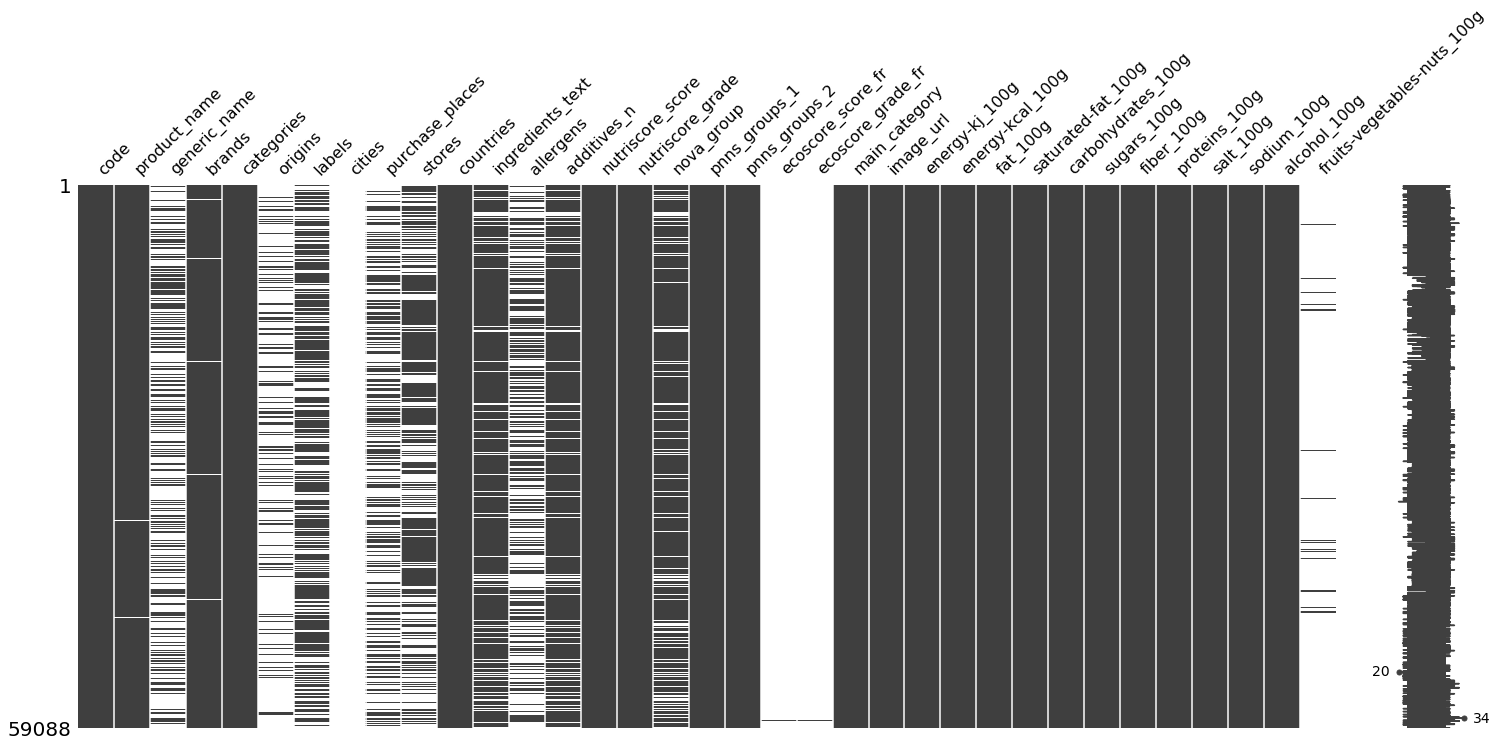

In [31]:
msno.matrix(df)

In [32]:
df.to_csv (r'export_dataframe.csv', index = False, header=True, sep='\t')

Maintenant que nous avons traité tout le dataset nous l'enregistrons dans un nouveau fichier au format csv.

In [33]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

In [35]:
n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data = df[['energy-kcal_100g', "saturated-fat_100g", "fat_100g","sugars_100g", "carbohydrates_100g",
                'proteins_100g', 'sodium_100g', "fiber_100g","salt_100g"]]

X = data.values
features = data.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

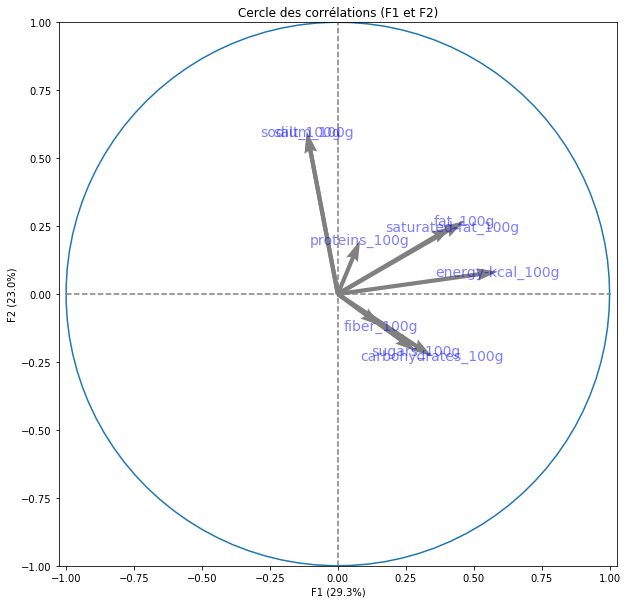

In [36]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

In [37]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.style import set_palette
set_palette('sns_pastel')

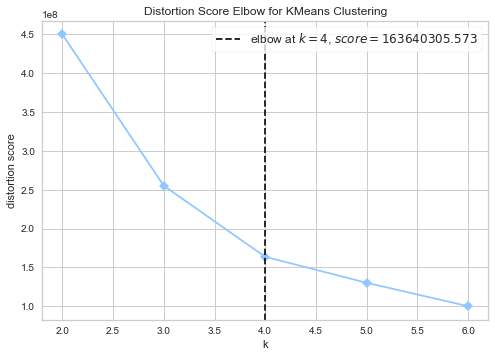

In [38]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,7), metric='distortion', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

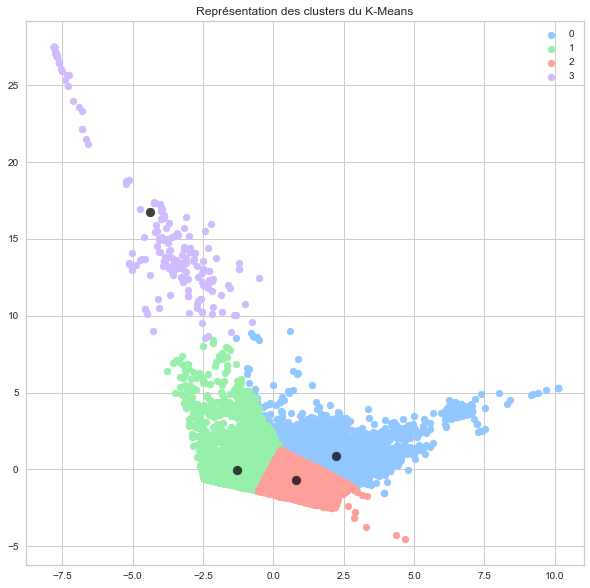

In [39]:
km = KMeans(n_clusters=4)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels = np.unique(label)
plt.figure(figsize=(10,10))

for i in u_labels:
    plt.scatter(pca_components[label == i , 0] , pca_components[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()